# KNN SVM LSTM GRU WITH ENSEMBLE

# SEPARATE CODE

In [1]:
import csv
import copy
import argparse
import itertools
from collections import Counter
from collections import deque
import pandas as pd
import cv2
import seaborn as sns
import numpy as np
import mediapipe as mp
import time
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,mean_squared_error, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical



In [2]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def show(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        return elapsed_time
    def stop(self):
        self._start_time=None

In [3]:
# Function to calculate landmark list
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Iterate over each landmark point
    for _, landmark in enumerate(landmarks.landmark):
        # Convert normalized coordinates to pixel coordinates
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z  # Uncomment this line if you need the z-coordinate

        # Append the pixel coordinates to the landmark_point list
        landmark_point.append([landmark_x, landmark_y])

    return landmark_point


# Function to preprocess landmarks
def pre_process_landmark(landmark_list):
    # Implement your preprocessing logic here
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list
    pass


# To Load A Label

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5)
cap = cv2.VideoCapture(0)  # Use the appropriate index or video file path
keyy = 1
t = Timer()
while keyy != 0:
    label = input("Enter label")
    label=" "+label
    with open("label.txt",'r') as f:
        la=f.read().split()
        size=len(la)
        print(size)
    with open('label.txt','a+') as f:
        print(f.read())
        f.write(label)
    t.start()
    while t.show() < 120.0 and cap.isOpened():
        ret, frame = cap.read()

        # BGR 2 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Flip on horizontal
        image = cv2.flip(image, 1)
        debug_image = copy.deepcopy(image)

        # Set flag
        image.flags.writeable = False

        # Detections
        results = hands.process(image)

        # Set flag to true
        image.flags.writeable = True

        # RGB 2 BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Rendering results
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                landmark_list = calc_landmark_list(debug_image, hand_landmarks)
                l=pre_process_landmark(landmark_list)
                l.insert(0,size)
                #print("Iterations:",l)
                #print(pre_processed_landmark_list)
                x, y, w, h = cv2.boundingRect(np.array(landmark_list))
                cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                hand_label = "Left Hand" if handedness.classification[0].label == "Left" else "Right Hand"
                cv2.putText(debug_image, hand_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                mp_drawing.draw_landmarks(debug_image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                          )
                with open("training_data.csv",'a+',newline='') as f:
                    writer=csv.writer(f)
                    #print(l)
                    writer.writerow(l)
    keyy = int(input("Continue?"))
    t.stop()

cap.release()
cv2.destroyAllWindows()
hands.close()

In [4]:
labels_file = 'label.txt'
with open(labels_file, 'r') as f:
    labels = f.read().split()

data_file = 'training_data.csv'
unique_words = set()
with open(data_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        unique_words.update(row)

word_index = {word: index for index, word in enumerate(unique_words)}
label_index_mapping = {label: index for index, label in enumerate(labels)}
print(label_index_mapping)

{'Number_1': 0, 'Number_2': 1, 'Number_3': 2, 'Number_4': 3, 'Number_5': 4, 'Number_6': 5, 'Number_7': 6, 'Number_8': 7, 'Number_9': 8, 'Alphabet_A': 9, 'Alphabet_B': 10, 'Alphabet_C': 11, 'Alphabet_D': 12, 'Alphabet_E': 13, 'Alphabet_F': 14, 'Alphabet_G': 15, 'Alphabet_H': 16, 'Alphabet_I': 17, 'Alphabet_J': 18, 'Alphabet_K': 19, 'Alphabet_L': 20, 'Alphabet_M': 21, 'Alphabet_N': 22, 'Alphabet_O': 23, 'Alphabet_P': 24, 'Alphabet_Q': 25, 'Alphabet_R': 26, 'Alphabet_S': 27, 'Alphabet_T': 28, 'Alphabet_U': 29, 'Alphabet_V': 30, 'Alphabet_W': 31, 'Alphabet_X': 32, 'Alphabet_Y': 33, 'Alphabet_Z': 34}


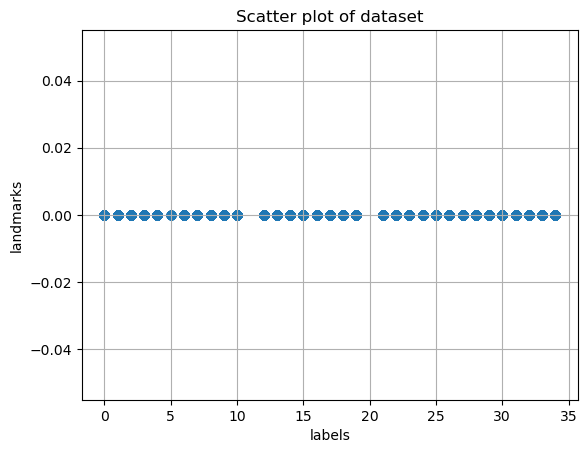

In [5]:
data=pd.read_csv('training_data.csv',header=None)
data.head()
plt.scatter(data[0],data[1])
plt.xlabel('labels')
plt.ylabel('landmarks')
plt.title('Scatter plot of dataset')
plt.grid(True)
plt.show()

# To Train the data

In [6]:
y=data.iloc[:,0]
x=data.iloc[:,1:]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.20,random_state=77)

In [7]:
y.shape

(41246,)

In [8]:
x.shape

(41246, 42)

In [9]:
xtrain.shape

(32996, 42)

In [10]:
xtest.shape

(8250, 42)

In [11]:
ytrain.shape

(32996,)

In [12]:
ytest.shape

(8250,)

In [13]:
y.axes

[RangeIndex(start=0, stop=41246, step=1)]

In [14]:
x.axes

[RangeIndex(start=0, stop=41246, step=1),
 Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
             18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
             35, 36, 37, 38, 39, 40, 41, 42],
            dtype='int64')]

In [15]:
y.size


41246

In [16]:
x.size

1732332

# Normalizing the data

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# To calculate accuracy for KNN

Accuracy for K-NN Algorithm -- >  99.13939393939394  %

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      0.99      0.99       274
           2       0.95      0.93      0.94       204
           3       0.97      0.97      0.97       198
           4       0.98      0.98      0.98       179
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        35
           7       1.00      0.98      0.99       191
           8       1.00      1.00      1.00       203
           9       1.00      1.00      1.00       229
          10       1.00      0.99      1.00       352
          12       0.98      0.98      0.98        57
          13       1.00      1.00      1.00        54
          14       0.99      0.98      0.98       230
          15       0.99      1.00      1.00       260
          16       0.98      1.00      0.99       247
  

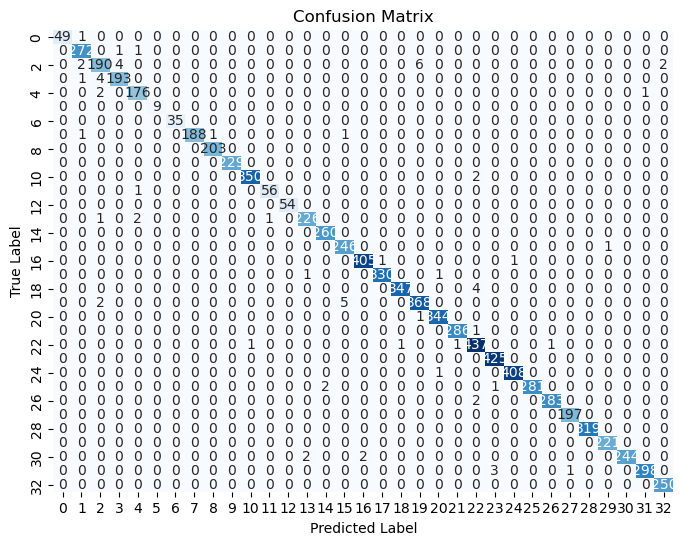

In [18]:
#Neighbours = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain,ytrain)
pred=knn.predict(xtest)
acc=knn.score(xtest,ytest)
print("Accuracy for K-NN Algorithm -- > ",acc*100," %")

print("\nClassification Report:")
print(classification_report(ytest, pred))
cm = confusion_matrix(ytest, pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

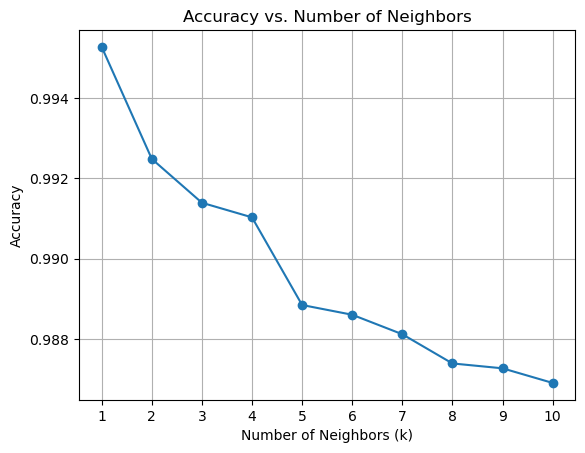

In [19]:
neighbors = list(range(1, 11))  # You can adjust this range as needed
accuracies = []
for k in neighbors:
    # Initialize KNN classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the model
    knn.fit(xtrain, ytrain)
    pred = knn.predict(xtest)
    # Calculate accuracy and append to list
    acc = accuracy_score(ytest, pred)
    accuracies.append(acc)
# Plot the graph
plt.plot(neighbors, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(neighbors)
plt.grid(True)
plt.show()

# To calculate accuracy for SVM

In [20]:
clf = svm.SVC()
clf.fit(xtrain,ytrain)
spred=clf.predict(xtest)
sacc=clf.score(xtest,ytest)
print("Accuracy for SVM Algoritm -- > ",sacc*100, "%")

print("\nClassification Report:")
print(classification_report(ytest, spred))

Accuracy for SVM Algoritm -- >  96.5939393939394 %

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        50
           1       0.96      0.99      0.97       274
           2       0.95      0.75      0.84       204
           3       0.81      0.96      0.88       198
           4       0.93      0.98      0.95       179
           5       1.00      1.00      1.00         9
           6       1.00      0.94      0.97        35
           7       1.00      0.96      0.98       191
           8       1.00      1.00      1.00       203
           9       1.00      1.00      1.00       229
          10       0.99      0.95      0.97       352
          12       1.00      0.98      0.99        57
          13       0.98      1.00      0.99        54
          14       0.99      0.95      0.97       230
          15       0.98      1.00      0.99       260
          16       0.96      0.85      0.90       247
      

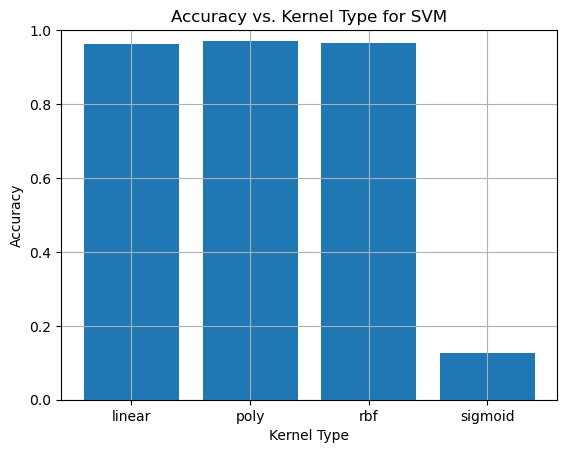

In [21]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# Initialize lists to store accuracy scores
accuracies = []
# Loop through different kernel types
for kernel in kernels:
    # Initialize SVM classifier with the specified kernel
    clf = svm.SVC(kernel=kernel)
    clf.fit(xtrain, ytrain)
    spred = clf.predict(xtest)
    sacc = accuracy_score(ytest, spred)
    accuracies.append(sacc)
plt.bar(kernels, accuracies)
plt.title('Accuracy vs. Kernel Type for SVM')
plt.xlabel('Kernel Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limits to better visualize differences
plt.grid(True)
plt.show()

# To Calculate accuracy for LSTM

In [22]:
# Reshape input data for LSTM
y=to_categorical(y)
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.20,random_state=0)

xtrain_lstm = xtrain_scaled.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest_lstm = xtest_scaled.reshape((xtest.shape[0], xtest.shape[1], 1))

In [23]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='linear', input_shape=(42,1)))
model.add(LSTM(128, return_sequences=True, activation='linear'))
model.add(LSTM(64, return_sequences=False, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(35, activation='softmax'))

C:\Users\Admin\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 42, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 42, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 35)                  │           1,155 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,515 (673.89 KB)

 Trainable params: 172,515 (673.89 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [26]:
yt=ytrain.reshape(-1,1)
ytrain.shape

(32996, 35)

In [27]:
# Train the model for lstm
history = model.fit(xtrain, ytrain, epochs=5, batch_size=64, validation_data=[xtest,ytest], verbose=1)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - accuracy: 0.1858 - loss: 2.7482 - val_accuracy: 0.5495 - val_loss: 1.3182
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 59s 113ms/step - accuracy: 0.6393 - loss: 1.0474 - val_accuracy: 0.6832 - val_loss: 1.1371
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 61s 118ms/step - accuracy: 0.4042 - loss: 2.4376 - val_accuracy: 0.5966 - val_loss: 1.1896
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.6676 - loss: 1.0161 - val_accuracy: 0.8004 - val_loss: 0.6164
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 59s 113ms/step - accuracy: 0.8004 - loss: 0.6072 - val_accuracy: 0.7943 - val_loss: 0.6058


In [28]:
best_model = load_model('best_model.h5')

OSError: Unable to synchronously open file (file signature not found)

In [29]:
# Evaluate on test data lstm
test_loss, test_accuracy = model.evaluate(xtest, ytest)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy BiLSTM: {test_accuracy:.4f}")

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7876 - loss: 0.6269
Test Loss: 0.6058, Test Accuracy BiLSTM: 0.7943


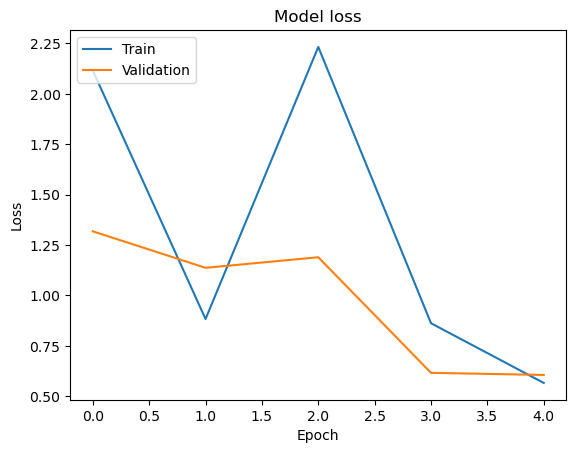

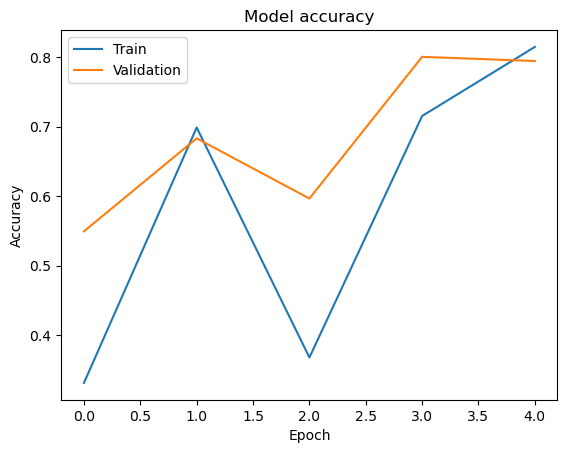

In [30]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# To Calculate accuracy for GRU

In [31]:
xtrain_gru = xtrain_scaled.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest_gru = xtest_scaled.reshape((xtest.shape[0], xtest.shape[1], 1))

model = Sequential()
model.add(GRU(64, return_sequences=True, activation='linear', input_shape=(42,1)))
model.add(GRU(128, return_sequences=True, activation='linear'))
model.add(GRU(64, return_sequences=False, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(35, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 42, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 42, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 35)                  │           1,155 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,003 (515.64 KB)

 Trainable params: 132,003 (515.64 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
checkpoint = ModelCheckpoint('best_model_gru.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model_gru.h5

In [33]:
# Train the model for gru
history = model.fit(xtrain, ytrain, epochs=5, batch_size=64, validation_data=[xtest,ytest], verbose=1)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - accuracy: 0.2465 - loss: 2.5399 - val_accuracy: 0.8713 - val_loss: 0.3990
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.8926 - loss: 0.3550 - val_accuracy: 0.9265 - val_loss: 0.2555
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.9337 - loss: 0.2237 - val_accuracy: 0.9550 - val_loss: 0.1854
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.9494 - loss: 0.1715 - val_accuracy: 0.9457 - val_loss: 0.1904
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.9591 - loss: 0.1328 - val_accuracy: 0.9538 - val_loss: 0.1765


In [34]:
# Evaluate on test data gru
test_loss, test_accuracy = model.evaluate(xtest, ytest)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy GRU: {test_accuracy:.4f}")

258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9510 - loss: 0.1903
Test Loss: 0.1765, Test Accuracy GRU: 0.9538


In [35]:
best_model = load_model('best_model_gru.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model_gru.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

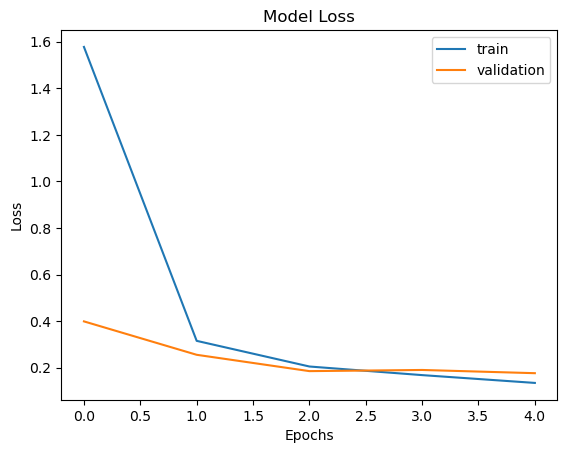

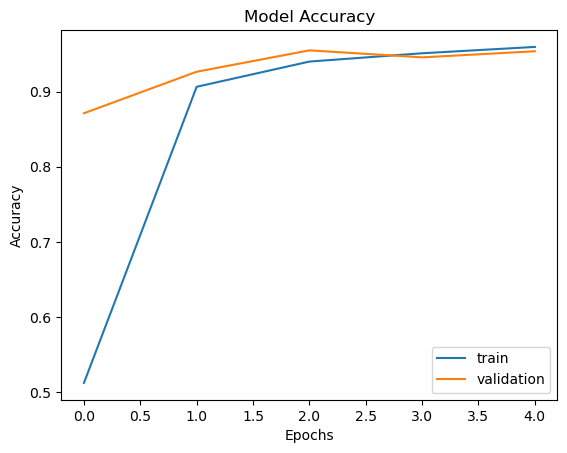

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# For Realtime Prediction

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5)
cap = cv2.VideoCapture(0)  # Use the appropriate index or video file path

recognition_times_knn = []  # To store recognition times for k-NN
recognition_times_svm = []  # To store recognition times for SVM
recognition_times_lstm = [] #To store recognition times for LSTM
recognition_times_gru = [] #To store recognition times for GRU


print("K-NN \t SVM \t BiLSTM \t GRU")
while cap.isOpened():
    ret, frame = cap.read()

    # BGR 2 RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Flip on horizontal
    image = cv2.flip(image, 1)
    debug_image = copy.deepcopy(image)

    # Set flag
    image.flags.writeable = False

    # Detections
    results = hands.process(image)

    # Set flag to true
    image.flags.writeable = True

    # RGB 2 BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    with open("label.txt",'r') as f:
        label=f.read().split()
        # Rendering results
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                    landmark_list = calc_landmark_list(debug_image, hand_landmarks)
                    pre_processed_landmark_list = pre_process_landmark(landmark_list)
                    x, y, w, h = cv2.boundingRect(np.array(landmark_list))
                    cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    hand_label = "Left Hand" if handedness.classification[0].label == "Left" else "Right Hand"
                    cv2.putText(debug_image, hand_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                    mp_drawing.draw_landmarks(debug_image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                                  mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                                  )
            data2 = pd.DataFrame([pre_processed_landmark_list])
            xi = data2.iloc[:,:]

            start_time = time.perf_counter()               #Record start time

            # Predict using k-NN
            pred = knn.predict(xi)
            #pred_knn = knn.predict([pre_processed_landmark_list])[0]
            end_time = time.perf_counter()                  # Record end time and calculate recognition time
            recognition_time_knn = end_time - start_time
            recognition_times_knn.append(recognition_time_knn)

            # Predict using SVM
            spred=clf.predict(xi)
            end_time = time.perf_counter()                 # Record end time and calculate recognition time
            recognition_time_svm = end_time - start_time
            recognition_times_svm.append(recognition_time_svm)

            # Predict using LSTM
            xi_lstm = np.array(xi).reshape((xi.shape[0], xi.shape[1],1))  # Reshape for LSTM input
            predictions_prob = model.predict(xi_lstm)
            pred_lstm = np.argmax(predictions_prob,axis=1)
            end_time = time.perf_counter()  # Record end time and calculate recognition time
            recognition_time_lstm = end_time - start_time
            recognition_times_lstm.append(recognition_time_lstm)

            # Predict using GRU
            xi_gru = np.array(xi).reshape((xi.shape[0], xi.shape[1], 1))  # Reshape for GRU input
            predictions_prob = model.predict(xi_gru)
            pred_gru = np.argmax(predictions_prob, axis=1)
            end_time = time.perf_counter()  # Record end time and calculate recognition time
            recognition_time_gru = end_time - start_time
            recognition_times_gru.append(recognition_time_gru)

            op=label[int(pred)]  #knn
            sop=label[int(spred)] #svm
            lop = label[int(pred_lstm)]  # biLSTM
            gop = label[int(pred_gru)]  # GRU
            print(" ")
            print(op, "\t", sop, "\t", lop, "\t", gop)

            predictions = [op, sop, lop, gop]  # Ensemble predicition
            max_vote = max(set(predictions), key=predictions.count)
            print("\nEnsemble Prediction:", max_vote)
            print(" ")

            time.sleep(1)
            cv2.putText(debug_image,str(op), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 255, 255), 2)
            time.sleep(1)
            cv2.imshow('Hand Tracking', debug_image)

            if cv2.waitKey(400) & 0xFF == ord('q'):
                break
print(" ")
# Calculate and print average recognition time for k-NN
avg_recognition_time_knn = sum(recognition_times_knn) / len(recognition_times_knn)
print("Average Recognition Time (k-NN):", avg_recognition_time_knn*1000, "ms")

# Calculate and print average recognition time for SVM
avg_recognition_time_svm = sum(recognition_times_svm) / len(recognition_times_svm)
print("Average Recognition Time (SVM):", avg_recognition_time_svm*1000, "ms")

# Calculate and print average recognition time for LSTM
avg_recognition_time_lstm = sum(recognition_times_lstm) / len(recognition_times_lstm)
print("Average Recognition Time (BiLSTM):", avg_recognition_time_lstm * 100, "ms")

# Calculate and print average recognition time for GRU
avg_recognition_time_gru = sum(recognition_times_gru) / len(recognition_times_gru)
print("Average Recognition Time (GRU):", avg_recognition_time_gru * 100, "ms")

cap.release()
cv2.destroyAllWindows()
hands.close()


K-NN 	 SVM 	 BiLSTM 	 GRU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 
Number_5 	 Alphabet_B 	 Alphabet_Y 	 Alphabet_Y

Ensemble Prediction: Alphabet_Y
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 
Alphabet_H 	 Alphabet_B 	 Number_5 	 Number_5

Ensemble Prediction: Number_5
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
 
Alphabet_Z 	 Alphabet_B 	 Number_4 	 Number_4

Ensemble Prediction: Number_4
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
 
Number_2 	 Alphabet_B 	 Number_2 	 Number_2

Ensemble Prediction: Number_2
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 
Number_2 	 Alphabet_B 	 Number_5 	 Number_5

Ensemble Prediction: Number_5
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 
Alphabet_G 	 Alphabet_M 	 Alphabet_G 	 Alphabet_G

Ensemble Prediction: Alphabet_G
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
pip install tensorflow

In [ ]:
pip install keras